# Summary
#  [Importing libraries](#Importing-libraries)
#  [Initial configuration](#Initial-configuration)
#  [Importing Excel spreadsheet](#Defining-functions)
#  [Importing Excel spreadsheet](#Importing-Excel-spreadsheet)
# [Setting up a local copy of the NCBI taxonomy database](#Setting-up-a-local-copy-of-the-NCBI-taxonomy-database)
# [Geting NCBI TAX IDs](#Geting-NCBI-TAX-IDs)
# [Creating dataframe with all microorganisms in the rows and the plastics in the columns](#Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns)
# [Filling the dataframe with plastic degrading data](#Filling-the-dataframe-with-plastic-degrading-data)
# [Getting tree topology from NCBI and creating the tree](#Getting-tree-topology-from-NCBI-and-creating-the-tree)
# [Creating Itol dataset files](#Creating-Itol-dataset-files)
# [Downloading all available genomes for the plastic degraders](#Downloading-all-available-genomes-for-the-plastic-degraders)
# [Creating itol dataset for microorganisms with available genomes](#Creating-itol-dataset-for-microorganisms-with-available-genomes)
# [Blasting genes against genomes](#Blasting-genes-against-genomes)
# [Creating itol datasets for genes](#Creating-itol-datasets-for-genes)

<a id='Importing-libraries'></a>
# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import random, os, time
from ete3 import NCBITaxa
from ete3 import Tree
import seaborn as sns
import unicodedata
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import operator

<a id='Initial-configuration'></a>
# Initial configuration

In [2]:
#If running on a Slurm cluster, change account name and change run_on_slurm variable to True.
account = "uoa00354"
run_on_slurm = True

<a id='Defining-functions'></a>
# Defining functions

In [3]:
def create_directory(directory_name):
    if os.path.exists(directory_name) == False:
        os.mkdir(directory_name)
    
def run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command):
    if run_on_slurm == False:
        os.system(job_command)
    if run_on_slurm == True:
        f = open("run.sh", "w")
        f.write("""#!/bin/bash

#SBATCH --account="""+str(account)+"""
#SBATCH --job-name="""+str(job_name)+"""
#SBATCH --time="""+str(job_time)+"""
#SBATCH --mem="""+str(job_memory)+"""
#SBATCH --cpus-per-task="""+str(job_cpus)+"""

module load Python/3.7.3-gimkl-2018b
module load BLAST


"""+job_command)
        f.close()
    
        os.system("sbatch run.sh")  
        os.system("rm run.sh")
    else:
        print("Please, set 'run_on_slurm' variable to True or False")
        
def is_error(func, *args, **kw):
    try:
        func(*args, **kw)
        return False
    except Exception:
        return True
    
def get_rank_count_percentage(rank,tax_id_list):
    rank_dict = {}
    for tax_id in tax_id_list:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                if tax_id_lineage not in rank_dict:
                    rank_dict[tax_id_lineage] = 1
                else:
                    rank_dict[tax_id_lineage] += 1
    sum = 0
    for key, value in rank_dict.items():
        sum += value
    for key, value in rank_dict.items():
        rank_dict[key] = (value/sum)*100
    return(rank_dict)

<a id='Importing-Excel-spreadsheet'></a>
# Importing Excel spreadsheet

In [4]:
df = pd.read_excel("Degraders_list_v4.xlsx")
#Visualize part of the dataset.
df.tail(7)

,Microorganism,Tax ID,Plastic,Ref,Enzyme,Gene,GenbankID,Sequence,Year,Evidence,Plastic used,Manufacturer,Analitical grade,Thermophilic conditions,Isolation sample type,Isolation environment,Isolation location,PMBD,Degradation extrapolated from enzyme
1196,Vibrio gazogenes,0,PCL,"Danso, D., Schmeisser, C., Chow, J., Zimmerman...",PET-hydrolase,Yes,ASA57064.1,MMNVLTKCKLALGIIAIFFSLPSFAVPCSDCSNGFERGQVPRVDQL...,2018.0,Clear zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Yes
1197,Vibrio gazogenes,0,PET,"Danso, D., Schmeisser, C., Chow, J., Zimmerman...",PET-hydrolase,Yes,ASA57064.1,MMNVLTKCKLALGIIAIFFSLPSFAVPCSDCSNGFERGQVPRVDQL...,2018.0,Clear zone;HPLC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,Yes
1198,Vibrio parahaemolyticus,0,LLDPE Blend,"Raghul, S. S., Bhat, S. G., Chandrasekaran, M....",No,No,NaN,NaN,2017.0,Tensilometer;SEM;Clear zone,Film-grade LLDPE with the density of 0.920 g/cm3,Reliance Industries,Fill me out,No,Sediment,Marine,India,No,No
1199,Vibrio parahaemolyticus,0,PVA Blend,"Raghul, S. S., Bhat, S. G., Chandrasekaran, M....",No,No,NaN,NaN,2016.0,Tensilometer;SEM;Clear zone,Molecular formula of polyvinyl alcohol is (C4H...,Rolex Chemical Industries,Fill me out,No,Sediment,Marine,India,No,No
1200,Vibrio sp.,0,PET,"Sarkhel, R., Sengupta, S., Das, P., & Bhowal, ...",No,No,NaN,NaN,2020.0,Weight loss;FTIR;SEM;X-ray,"In this study, polymer films were obtained mai...",NaN,No,No,Water,Mangrove,India,No,No
1201,Virgibacillus halodenitrificans,0,PE,"Roy, P. K., Titus, S., Surekha, P., Tulsi, E.,...",No,No,NaN,NaN,2008.0,MS;Weight loss;TGA;Tensilometer;FTIR;SEM;DSC,General purpose film grade ‘LDPE 24FS040’ has ...,NaN,NaN,No,Collection,Collection,NaN,No,No
1202,Xanthomonas sp.,0,PHPV,"Kim, H., Ju, H. S., & Kim, J. (2000). Characte...",PHPV depolymerase,No,NaN,NaN,2000.0,Clear zone,PHPV was produced by growing Pseudomonas putid...,NaN,Yes,No,Water,Sewage/Sludge,NaN,No,No


<a id='Setting-up-a-local-copy-of-the-NCBI-taxonomy-database'></a>
# Setting up a local copy of the NCBI taxonomy database

In [5]:
ncbi = NCBITaxa()

<a id='Geting-NCBI-TAX-IDs'></a>
# Geting NCBI TAX IDs

In [6]:
#If it returns an error, just wait, it will get the dataframe anyway.
for index, row in df.iterrows():
    if row["Tax ID"] == 0:
        name2taxid = ncbi.get_name_translator([row["Microorganism"]])
        df["Tax ID"][row.name] = str(name2taxid.values()).replace("[","").replace("]","").split("(")[1].split(")")[0]
# df.head(1180).tail(20)
for index, row in df.iterrows():
    if type(row["Tax ID"]) != int:
        print(row["Microorganism"])

/home/vmar559/PyPackages/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<a id='Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns'></a>
# Creating dataframe with all microorganisms in the rows and the plastics in the columns

In [7]:
plastic_types = df['Plastic'].unique()
tax_ids = df['Tax ID'].unique()
df2 = pd.DataFrame(0, index=tax_ids, columns=plastic_types)
df2.sort_index(inplace=True)
df2.sort_index(axis=1, inplace=True)
df2.head(7)

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,LLDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,...,PTC,PTS,PU,PU Blend,PVA,PVA Blend,PVC,PVC Blend,Sky-Green,Treated-HDPE
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Filling-the-dataframe-with-plastic-degrading-data'></a>
# Filling the dataframe with plastic degrading data

In [8]:
references_dict = {}
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    reference = str(row['Ref'].strip())
    normalized = unicodedata.normalize('NFD', reference)
    reference = u"".join([c for c in normalized if not unicodedata.combining(c)])+"<br><br>"
    df2.at[tax_id, plastic] = 1
    if tax_id not in references_dict.keys():
        references_dict[tax_id] = reference
    else:
        if reference not in references_dict[tax_id]:
            references_dict[tax_id] += reference
df2

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,LLDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,...,PTC,PTS,PU,PU Blend,PVA,PVA Blend,PVC,PVC Blend,Sky-Green,Treated-HDPE
192,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Getting-tree-topology-from-NCBI-and-creating-the-tree'></a>
# Getting tree topology from NCBI and creating the tree

In [11]:
ids = df2.index.values
t = ncbi.get_topology(ids, intermediate_nodes=True)
t.write(format=8, outfile="tree.nw")

<a id='Creating-Itol-dataset-files'></a>
# Creating Itol dataset files

In [34]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes
create_directory("itol_datasets")

for column in df2.columns:
    f = open("itol_datasets/"+column.rstrip()+".txt", "w")
    f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,"""+column+"""
COLOR,"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")
    for index, row in df2.iterrows():
        tax_id = str(index)
        feature_binary = str(row[column])
        f.write("\n"+tax_id+","+feature_binary)
    f.close()

<a id='Downloading-all-available-genomes-for-the-plastic-degraders'></a>
# Downloading all available genomes for the plastic degraders

In [33]:
for tax_id in tax_ids[400:]:
    job_name = str(tax_id)
    job_time = "08:00:00"
    job_memory = 200 #Amount of ram memory in MB
    job_cpus = 1
    job_command = "ncbi-genome-download -s genbank --format fasta --taxid "+str(tax_id)+" -r 5 -o genomes/"+str(tax_id)+"/ fungi,bacteria &"
    run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
    time.sleep(5)

Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or False
Please, set 'run_on_slurm' variable to True or

<a id='Creating-itol-dataset-for-microorganisms-with-available-genomes'></a>
# Creating itol dataset for microorganisms with available genomes

In [58]:
create_directory("itol_datasets_genomes")
directories_list = os.listdir("genomes")

f = open("itol_datasets_genomes/Available_genomes.txt", "w")
f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,Available genomes
COLOR,#FF0000
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")

for index, row in df2.iterrows():
    tax_id = str(index)
    if str(index) in directories_list:
        f.write("\n"+tax_id+","+"1")
    else:
        f.write("\n"+tax_id+","+"0")
f.close()

<a id='Blasting-genes-against-genomes'></a>
# Blasting genes against genomes

In [64]:
#Adding the TAX ID to all sequence names
directories_list = os.listdir("genomes")
create_directory("genomes_database")
os.system("touch genomes_database/genomes.fasta")
for directory in directories_list:
    os.system("zcat genomes/"+directory+"/genbank/*/*/*genomic.fna.gz | sed s/'^>'/'>"+directory+"_"+"'/g >> genomes_database/genomes.fasta")

#Creating BLAST database
job_time = "02:00:00"
job_memory = 4096 #Amount of ram memory in MB
job_cpus = 1
job_name = "blast_db"
job_command = "makeblastdb -in genomes_database/genomes.fasta -dbtype nucl"
run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)

#Sending BLAST jobs
create_directory("blasts")
job_time = "04:00:00"
job_memory = 512 #Amount of ram memory in MB
job_cpus = 1
for index, row in df.iterrows():
    sequences = row["Sequence"]
    species_name = ncbi.get_taxid_translator([row["Tax ID"]])[row["Tax ID"]].replace("(","").replace(")","").replace(":","").replace(" ","_")
    if pd.notna(sequences) == True:
        for n in range(0, len(sequences.split(";"))):
            job_name = str(row["Tax ID"])+"_"+str(n)
            job_command = "echo '"+sequences.split(";")[n]+"' | tblastn -query - -db /nesi/nobackup/uoa00354/victor/PlasticDegradersTree/genomes_database/genomes.fasta -out /nesi/nobackup/uoa00354/victor/PlasticDegradersTree/blasts/"+species_name+"_"+row["Enzyme"].replace(" ","_")+"_"+str(n)+".tsv -outfmt 6"
            run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
            time.sleep(2)


<a id='Creating-itol-datasets-for-all-genes'></a>
# Creating itol datasets for all genes

In [93]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes
blast_outputs_list = os.listdir("blasts")
blast_outputs_list.sort()
for file in blast_outputs_list:
    file_blast = open("blasts/"+file)
    blast = file_blast.readlines()
    file_itol = open("itol_datasets_genomes/"+file.replace("tsv", "txt"), "w")
    counting_dict = {}
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            if sseqid not in counting_dict:
                counting_dict[sseqid] = 1
            else:
                counting_dict[sseqid] += 1
                
    file_itol.write("""DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
COLOR\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_COLORS\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_LABELS\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
DATA""")    
    for index, row in df2.iterrows():
        if str(index) in counting_dict:
            file_itol.write("\n"+str(index)+"\t"+str(counting_dict[str(index)]))
        else:
            file_itol.write("\n"+str(index)+"\t0")
    file_blast.close()
    file_itol.close()

<a id='Creating-one-light-color-for-each-phylum'></a>
# Creating one light color for each phylum

In [12]:
phylum_color_dict = {}
phylum_color_list = []
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list))).as_hex()
n = 0
for item in phylum_color_list:
    phylum_color_dict[item] = phylum_colors[n]
    n += 1

<a id='Creating-itol-datasets-for-phylum-labels'></a>
# Creating itol datasets for phylum labels

In [14]:
'''
#Nexus version
f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")      
f.close()

#XML version

ids = df2.index.values

f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+str(key)+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")
f.close()

'''
ids = df2.index.values
internal_node_dict = {"Mucoromycota": "I867",
                      "Bacteroidetes": "I533",
                      "Cyanobacteria": "I255",
                      "Basidiomycota": "I557",
                      "Firmicutes": "I152",
                      "Actinobacteria": "I4",
                      "Proteobacteria": "I264",
                      "Ascomycota": "I625"}
f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+internal_node_dict[phylum_name]+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")
f.close()

<a id='Creating-itol-datasets-for-phylum-colored-ranges'></a>
# Creating itol datasets for phylum colored ranges

In [15]:
'''
f = open("itol_datasets/Phylum_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict[phylum_name]+","+phylum_name)
f.close()

'''

f = open("itol_datasets/Phylum_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+internal_node_dict[phylum_name]+",range,"+phylum_color_dict[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-references'></a>
# Creating itol datasets for references

In [16]:
f = open("itol_datasets/Popup_info.txt", "w")
f.write("""POPUP_INFO
SEPARATOR TAB
DATA
""")
for index, row in df2.iterrows():
    organism_name = ncbi.get_taxid_translator([index])[index]
    html_string = "<h1>"+organism_name+"</h1><br>NCBI ID = "+str(index)+"<br><br>References:<br><br>"+references_dict[index]
    f.write("\n"+str(index)+"\t"+organism_name+"\t"+html_string)
f.close()

<a id='Creating-file-with-TAX-IDs'></a>
# Creating file with TAX IDs

In [98]:
ids = df2.index.values
f = open("ids.txt", "w")
for item in ids:
    f.write(str(item)+"\n")
f.close()

<a id='Creating-tree-with-all-species'></a>
# Creating tree with all species

In [99]:
#Full Bacteria and Fungi version
all_species_file = open("all_species_tax_ids.txt")
all_species = all_species_file.readlines()
all_bacteria_and_fungi = []
for item in all_species:
    tax_id = item.rstrip()
    if is_error(ncbi.get_lineage, tax_id) == False:
        lineage = ncbi.get_lineage(tax_id)
        is_bacteria_or_fungi = 0
        is_unclassified = 0
        is_candidatus = 0
        for sub_item in lineage:
            if sub_item == 2 or sub_item == 4751:
                is_bacteria_or_fungi = 1
            if sub_item == 2323 or sub_item == 89443 or sub_item == 48479:
                is_unclassified = 1
            if "Candidatus" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
                is_candidatus = 1
            if "candidate" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
                is_candidatus = 1
        if is_bacteria_or_fungi == 1 and is_unclassified == 0 and is_candidatus == 0:
            all_bacteria_and_fungi.append(tax_id)          
all_bacteria_and_fungi_subsample = random.sample(all_bacteria_and_fungi, 7000)                              

for item in ids:
    all_bacteria_and_fungi_subsample.append(str(item))
t_all_species = ncbi.get_topology(all_bacteria_and_fungi_subsample, intermediate_nodes=True)
t_all_species.write(format=8, outfile="tree_all_species.nw")
f = open("all_species_tax_ids_subsampled.txt", "w")
for item in all_bacteria_and_fungi_subsample:
    f.write(item+"\n")
f.close()

<a id='Creating-one-light-color-for-each-phylum-for-all-species-tree'></a>
# Creating one light color for each phylum for all species tree

In [100]:
phylum_color_dict_all_species = {}
phylum_color_list_all_species = []
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list_all_species.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list_all_species))).as_hex()
n = 0
for item in phylum_color_list_all_species:
    phylum_color_dict_all_species[item] = phylum_colors[n]
    n += 1

<a id='Creating-itol-datasets-for-phylum-colored-ranges-for-all-species-tree'></a>
# Creating itol datasets for phylum colored ranges for all species tree

In [101]:
f = open("itol_datasets/Phylum_colors_all_species.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict_all_species[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-phylum-labels-for-all-species-tree'></a>
# Creating itol datasets for phylum labels for all species tree

In [102]:
f = open("itol_datasets/Phylum_labels_all_species.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict_all_species[phylum_name]+",bold,10,0")      
f.close()

<a id='Creating-itol-bar-dataset-for-all-species-tree'></a>
# Creating itol bar dataset for all species tree

In [103]:
file_itol = open("itol_datasets/bar_all_species.txt", "w")
file_itol.write("""DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL\tAll Species Bar
COLOR\t#0000ff
FIELD_COLORS\t#0000ff
FIELD_LABELS\tAll Species Bar
DATA""")    
for index, row in df2.iterrows():
    file_itol.write("\n"+str(index)+"\t10")
file_itol.close()

<a id='Creating-figure-with-number-of-publications-and-degraders-per-year'></a>
# Creating figure with number of publications and degraders per year

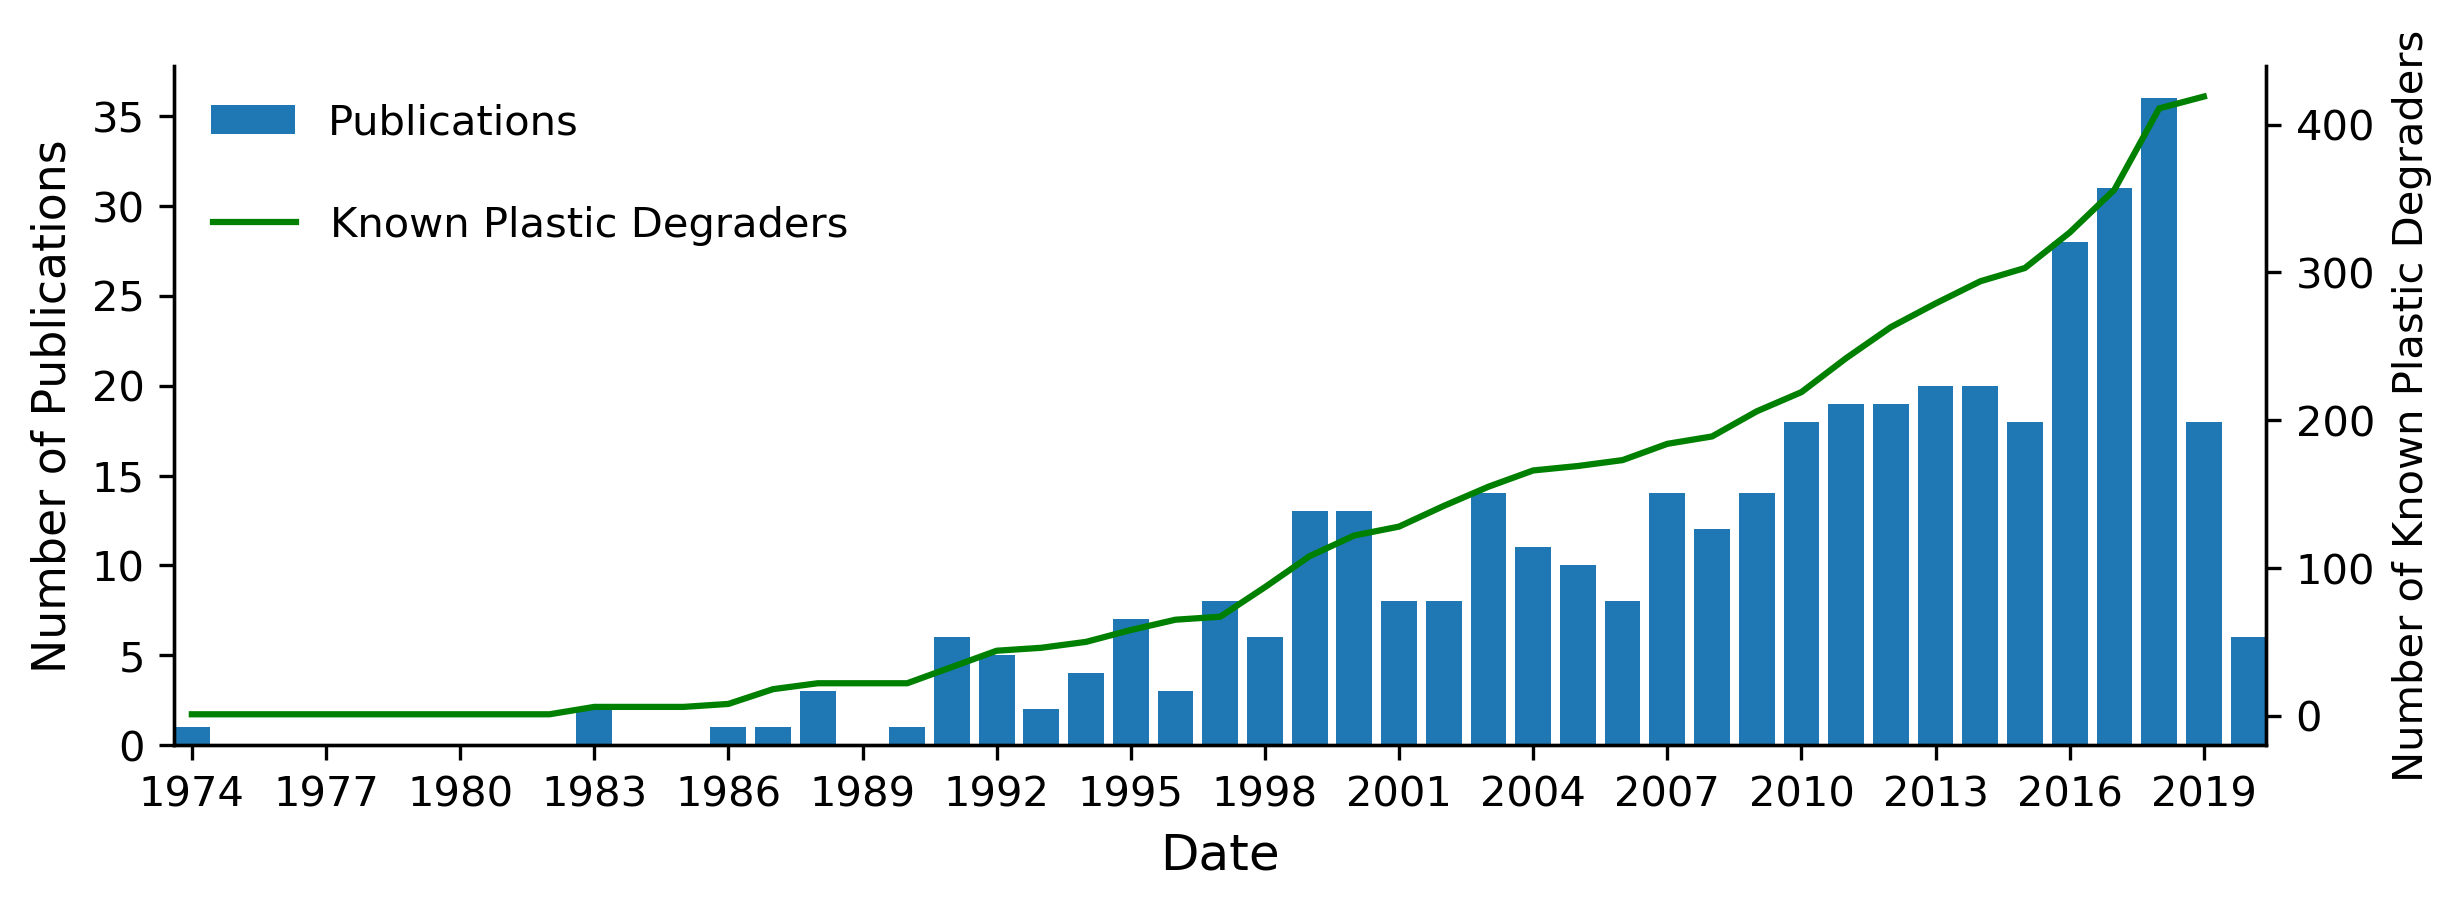

In [69]:
ref_dict, publication_count_dict = {}, {}
year_list = []

for index, row in df.iterrows():
    reference = row['Ref']
    year = row['Year']
    ref_dict[reference] = year

for key, value in ref_dict.items():
    year_list.append(value)
    if value not in publication_count_dict:
        publication_count_dict[value] = 1
    else:
        publication_count_dict[value] += 1

x, y = [], []

year_min = int(min(year_list))
year_max = int(max(year_list))

for n in range(year_min, year_max+1):
    if n in publication_count_dict:
        count = publication_count_dict[n]
        x.append(n)
        y.append(count)
    else:
        x.append(n)
        y.append(0)

figure(num=None, figsize=(9, 3), dpi=300, facecolor='w', edgecolor='k')
plt.clf()

ax1=plt.gca()
ax1.bar(x, y, label = "Publications")
ax1.set_ylabel("Number of Publications", fontsize=11)
ax1.set_xlabel("Date", fontsize=12)
ax1.legend(loc=0, frameon=False)
ax1.spines['top'].set_visible(False)

ids_year_dict = {}
year_count_dict = {}
x, y = [], []

for index, row in df.iterrows():
    ids = row['Tax ID']
    year = row['Year']
    if ids not in ids_year_dict:
        ids_year_dict[ids] = year
    else:
        if year < ids_year_dict[ids]:
            ids_year_dict[ids] = year

for key, value in ids_year_dict.items():
    if value not in year_count_dict:
        year_count_dict[value] = 1
    else:
        year_count_dict[value] += 1

year_sum = 0
for n in range(1974, 2020):
    if n in year_count_dict:
        year_sum += year_count_dict[n]
    x.append(n)
    y.append(year_sum)

ax2=ax1.twinx()
ax2.plot(x, y, color='green', label = "Known Plastic Degraders")
ax2.set_xticks(range(min(x), max(x)+1, 3))
ax2.set_ylabel("Number of Known Plastic Degraders", fontsize=10)
ax2.set_xlabel("Date", fontsize=12)
ax2.legend(loc=0, bbox_to_anchor=(0.34, 0.85,), frameon=False)
ax2.spines['top'].set_visible(False)

plt.margins(x=0)
plt.show()  

<a id='Creating-figure-with-stacked-bars-to-show-relative-abundance'></a>
# Creating figure with stacked bars to show relative abundance

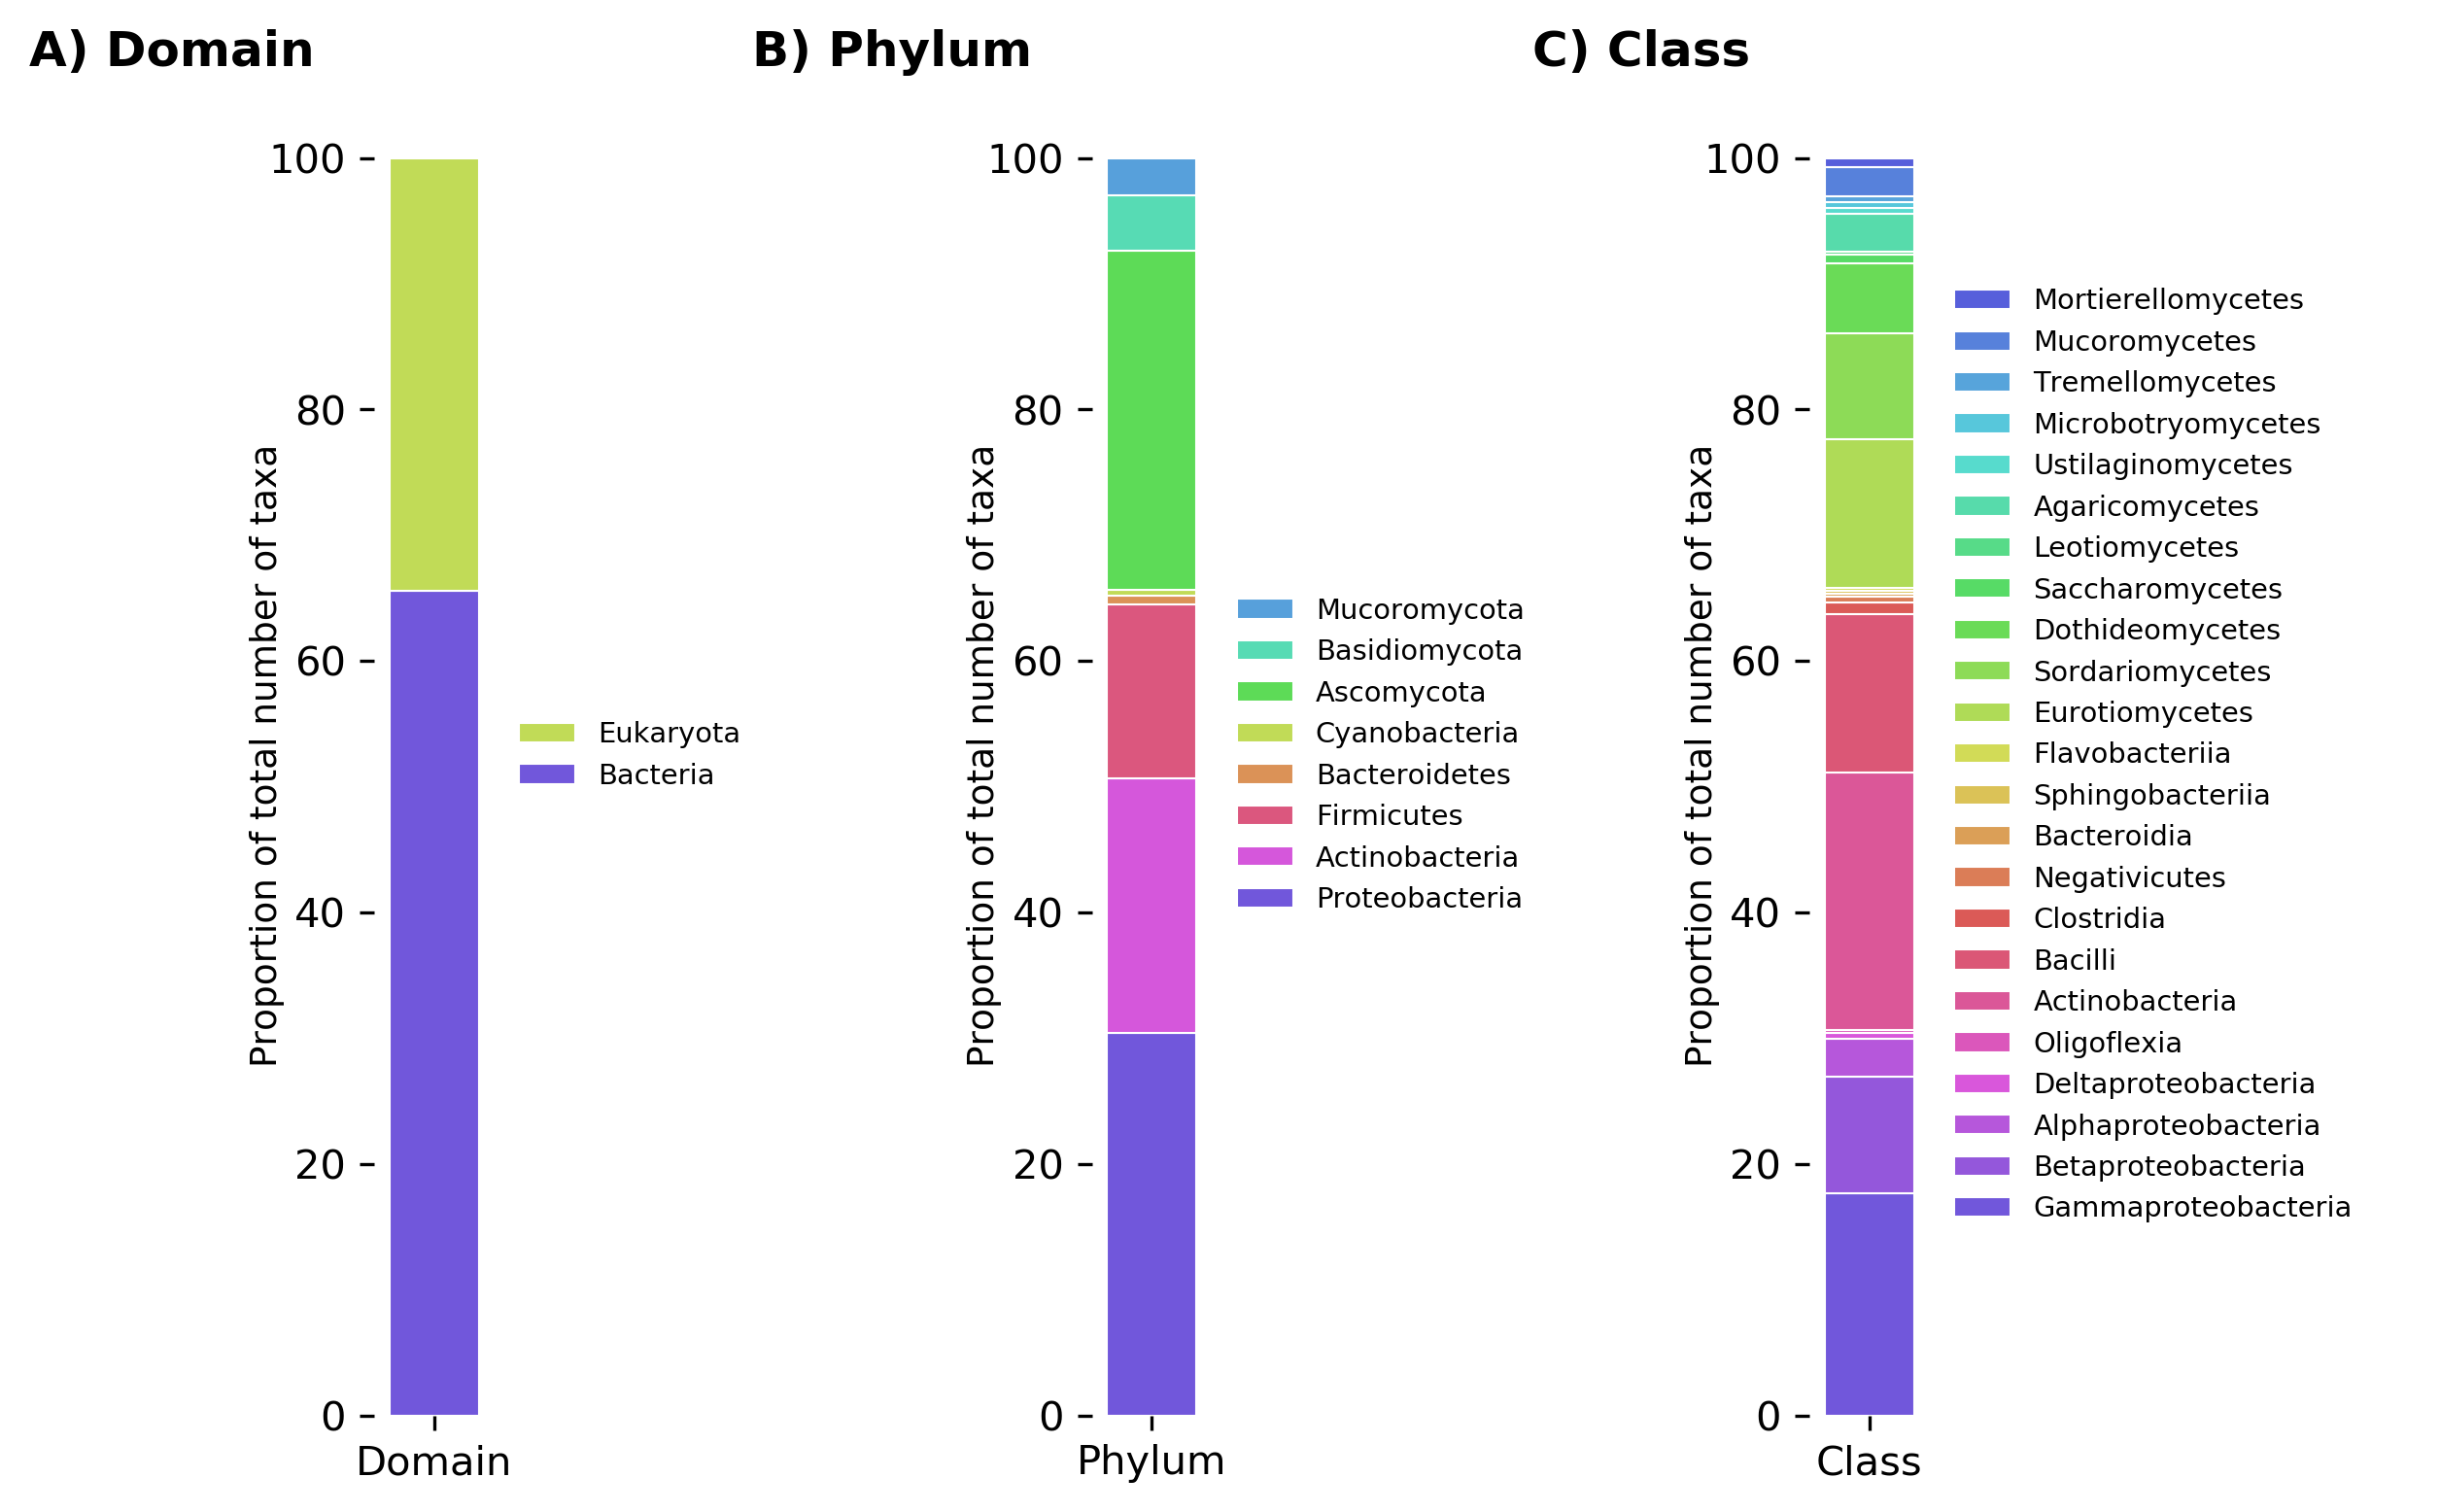

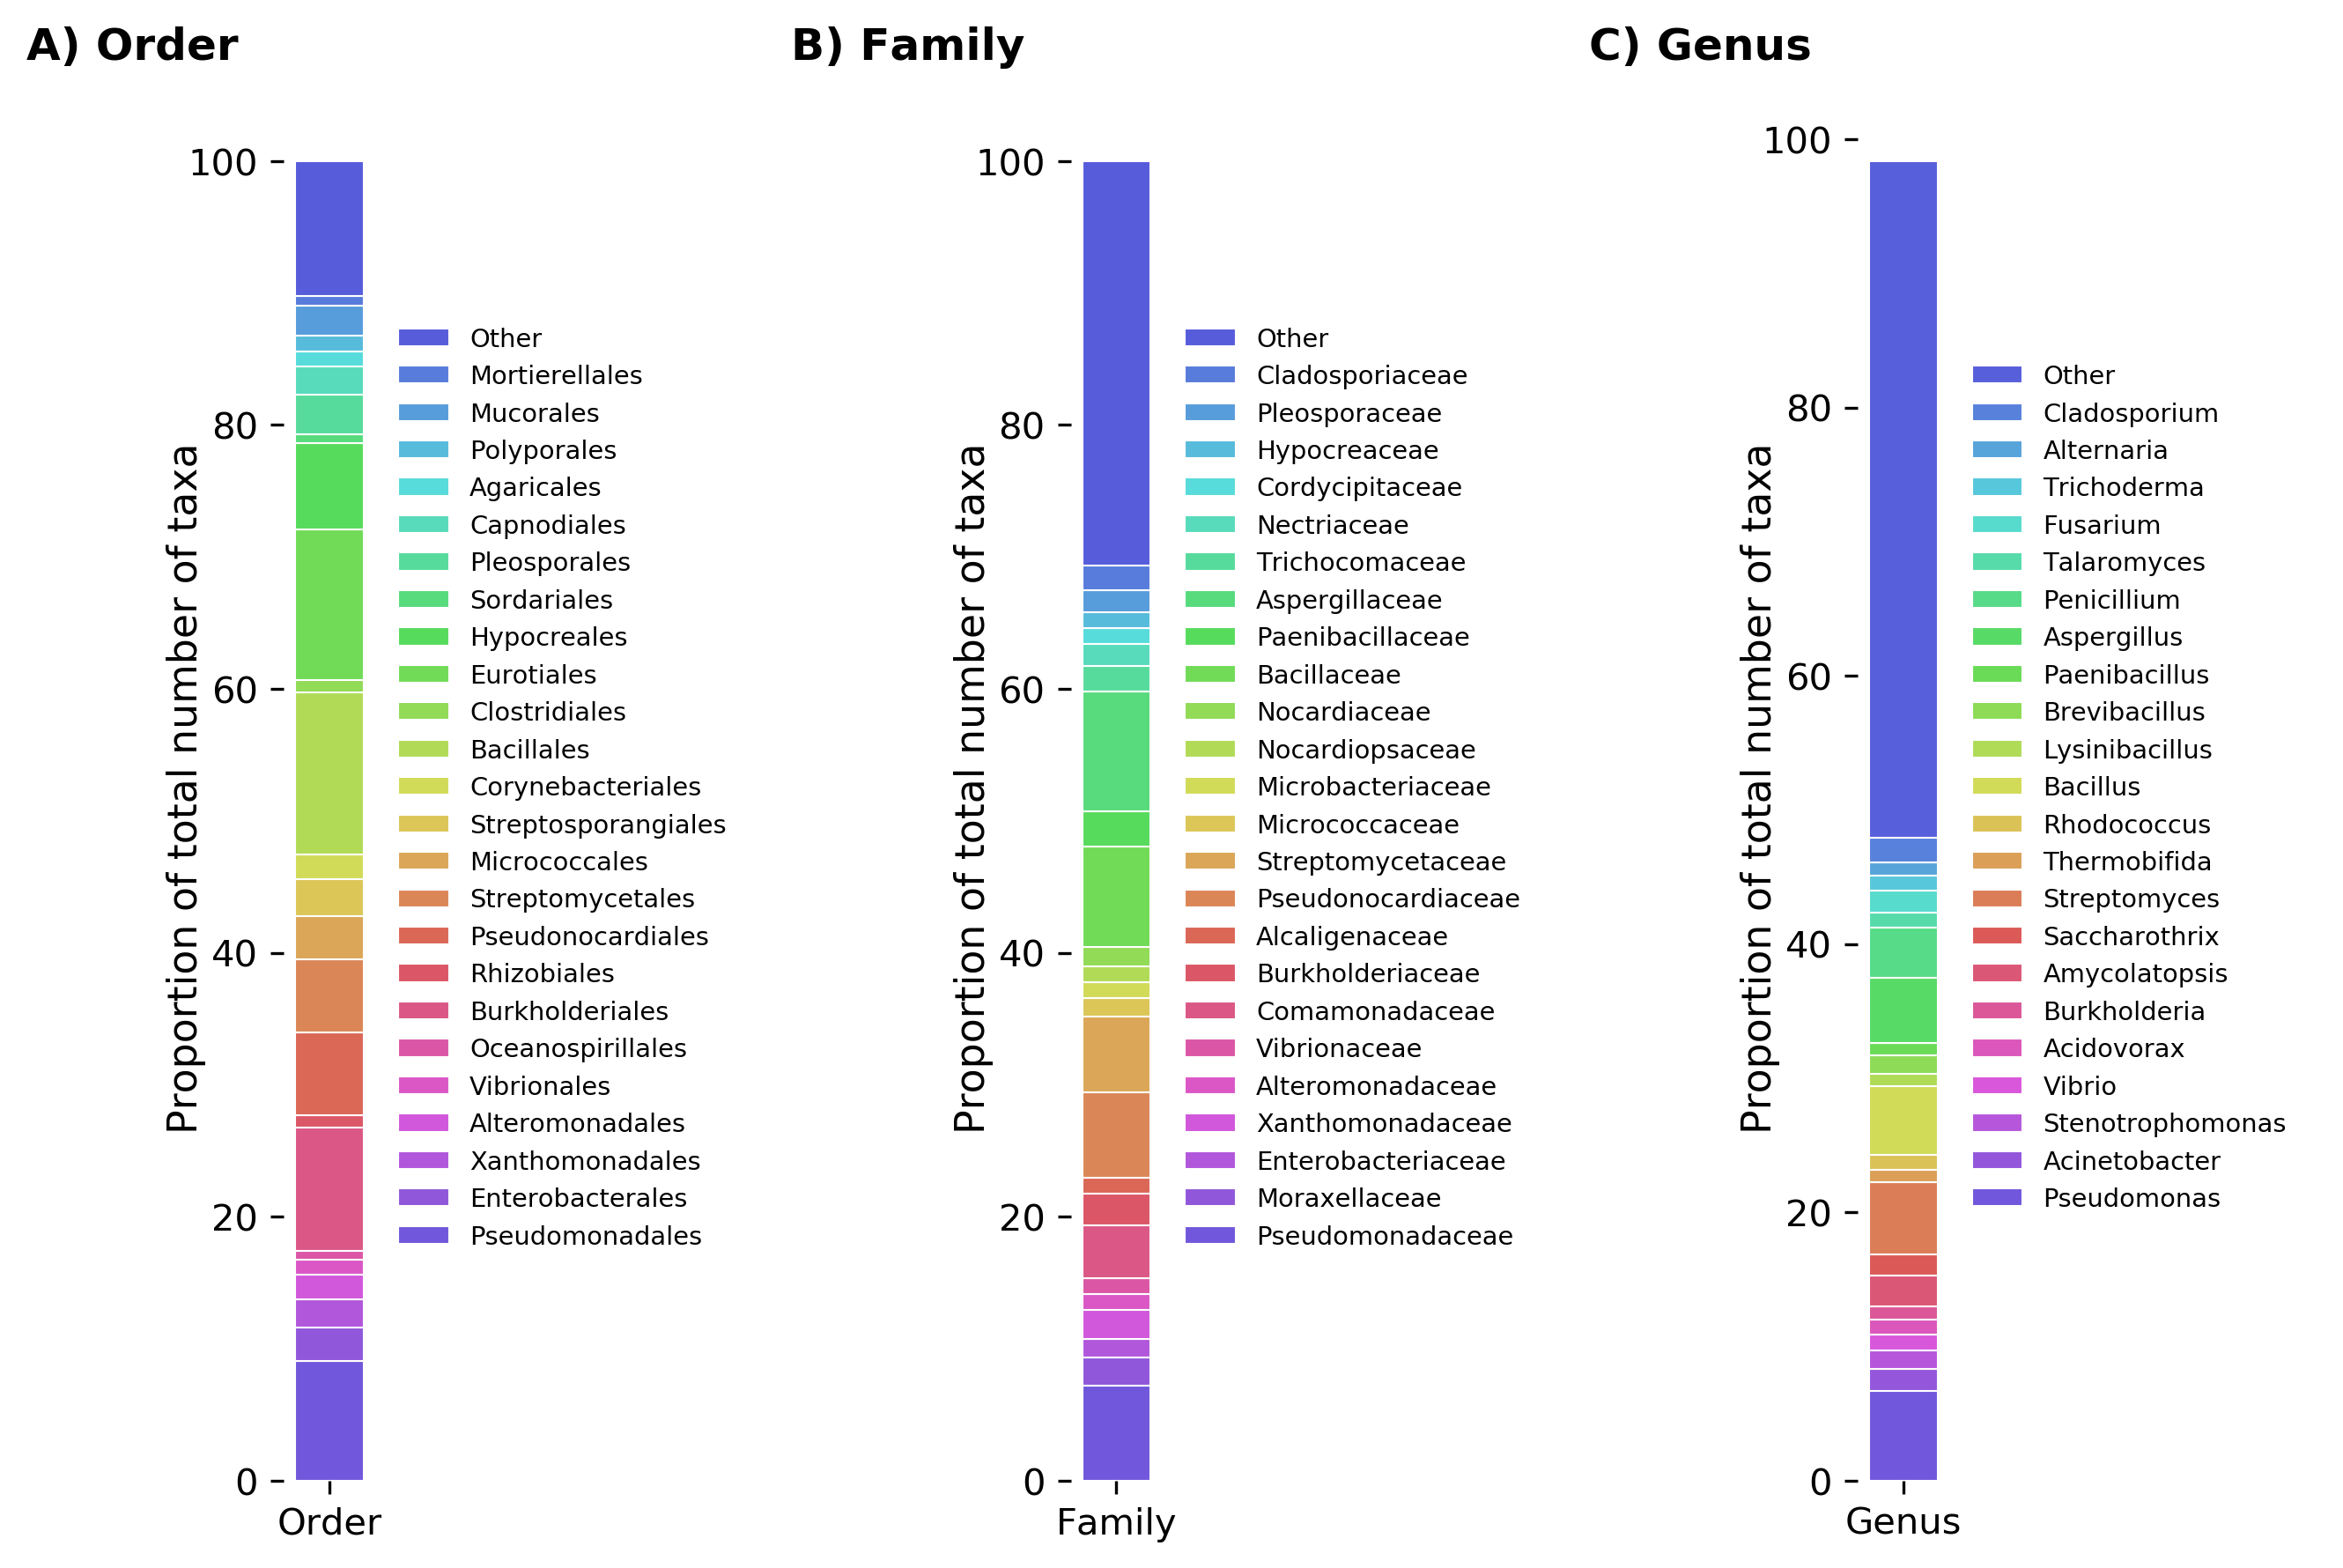

In [41]:
ids = df2.index.values

#Figure 1
figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')
levels_list = ["superkingdom", "phylum", "class"]
fig_number = 1
top_label_list = ["A) Domain", "B) Phylum", "C) Class"]

upper_level_list_old = []
upper_level_list_new = []
    
for level in levels_list:
    ax = plt.subplot(1, 3, fig_number)
    

    x, y = [], []
    level_dict = get_rank_count_percentage(level, ids)
    sorted_level = sorted(level_dict.items(), key=operator.itemgetter(1))[::-1]

    
    if fig_number == 1:
        for key, value in sorted_level:
            organism_name = ncbi.get_taxid_translator([key])[key]
            count = value
            x.append(organism_name)
            y.append(count)
            upper_level_list_old.append(key)
    else:
        for item in upper_level_list_old:  
            for key, value in sorted_level:
                organism_name = ncbi.get_taxid_translator([key])[key]
                count = value
                if is_error(ncbi.get_lineage, tax_id) == False:
                    lineage = ncbi.get_lineage(key)
                    for sub_item in lineage:
                        if sub_item == item:
                            x.append(organism_name)
                            y.append(count)
                            upper_level_list_new.append(key)

        upper_level_list_old = upper_level_list_new
        upper_level_list_new = []
            
    chart_colors = sns.hls_palette(len(x), h = 0.7, l = 0.6).as_hex()

    bottom_sum = 0
    for n in range(0, len(x)):
        y_list = [y[n]]
        x_list = [x[n]]
        ax.bar(1, y_list, color = chart_colors[n], width=1.5, bottom=bottom_sum, edgecolor='white', linewidth=0.5, label=x[n])
        bottom_sum += y[n]
    ax.set_ylabel("Proportion of total number of taxa", fontsize=9)
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if level == "superkingdom":
        plt.xticks([1], ["Domain"])
    else:
        plt.xticks([1], [level.capitalize()])
    plt.xlim(0, 10)
    handles,labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize = 'x-small', frameon=False, loc="center left", bbox_to_anchor=(0.2, 0.5,))
    plt.text(-0.1, 1.05, top_label_list[fig_number-1], fontweight='bold', transform=ax.transAxes, fontsize=12, va='top', ha='right')
    
    fig_number += 1
    
    
#Figure 2
figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')
levels_list = ["order", "family", "genus"]
fig_number = 1
top_label_list = ["A) Order", "B) Family", "C) Genus"]


for level in levels_list:
    ax = plt.subplot(1, 3, fig_number)
    
    x, y = [], []
    level_dict = get_rank_count_percentage(level, ids)
    sorted_level = sorted(level_dict.items(), key=operator.itemgetter(1))[::-1]
    
    
   
    sorted_level_count = 0
    sorted_level_sum = 0
    sorted_level_first_20 = []
    for key, value in sorted_level:
        if sorted_level_count < 24:
            sorted_level_first_20.append((key, value))
        else:
            if sorted_level_count == 24:
                sorted_level_first_20.append(("Other", 0))
            sorted_level_sum += value
            sorted_level_first_20[24] = ("Other", sorted_level_sum)
        sorted_level_count += 1
    
    for item in upper_level_list_old:  
        for key, value in sorted_level_first_20:
            if key != "Other":
                organism_name = ncbi.get_taxid_translator([key])[key]
                count = value
                if is_error(ncbi.get_lineage, tax_id) == False:
                    lineage = ncbi.get_lineage(key)
                    for sub_item in lineage:
                        if sub_item == item:
                            x.append(organism_name)
                            y.append(count)
                            upper_level_list_new.append(key)

    upper_level_list_old = upper_level_list_new
    upper_level_list_new = []
    x.append("Other")
    y.append(sorted_level_sum)
    
    
    chart_colors = sns.hls_palette(len(x), h = 0.7, l = 0.6).as_hex()

    bottom_sum = 0
    for n in range(0, len(x)):
        y_list = [y[n]]
        x_list = [x[n]]
        ax.bar(1, y_list, color = chart_colors[n], width=1.5, bottom=bottom_sum, edgecolor='white', linewidth=0.5, label=x[n])
        bottom_sum += y[n]
    ax.set_ylabel("Proportion of total number of taxa", fontsize=11)
    ax.yaxis.set_label_coords(-0.17,0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks([1], [level.capitalize()])
    plt.xlim(0, 10)
    handles,labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize = 'x-small', frameon=False, loc="center left", bbox_to_anchor=(0.2, 0.5,))
    plt.text(-0.1, 1.05, top_label_list[fig_number-1], fontweight='bold', transform=ax.transAxes, fontsize=12, va='top', ha='right')

    fig_number += 1
    
#Show both figures
plt.tight_layout()
plt.show()


<a id='Generating-number-of-plastic-types-degraded-by-each-species'></a>
# Generating number of plastic types degraded by each species

In [42]:
number_of_plastic_types_dict = {}
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    if tax_id not in number_of_plastic_types_dict:
        number_of_plastic_types_dict[tax_id] = [plastic]
    else:
        if plastic not in number_of_plastic_types_dict[tax_id]:
            number_of_plastic_types_dict[tax_id].append(plastic)

number_of_plastic_types_list = []
for key, value in number_of_plastic_types_dict.items():
    number_of_plastic_types_list.append([len(value), key])
number_of_plastic_types_list.sort()
print(number_of_plastic_types_list)

[[1, 192], [1, 232], [1, 239], [1, 285], [1, 293], [1, 301], [1, 317], [1, 354], [1, 358], [1, 479], [1, 549], [1, 573], [1, 599], [1, 678], [1, 876], [1, 959], [1, 1085], [1, 1273], [1, 1288], [1, 1306], [1, 1397], [1, 1405], [1, 1422], [1, 1479], [1, 1482], [1, 1673], [1, 1720], [1, 1785], [1, 1824], [1, 1829], [1, 1830], [1, 1833], [1, 1877], [1, 1881], [1, 1887], [1, 1952], [1, 2017], [1, 2020], [1, 2026], [1, 2030], [1, 2065], [1, 2072], [1, 4847], [1, 5041], [1, 5045], [1, 5046], [1, 5077], [1, 5078], [1, 5079], [1, 5082], [1, 5325], [1, 5341], [1, 5365], [1, 5481], [1, 5516], [1, 5530], [1, 5537], [1, 5541], [1, 5599], [1, 12917], [1, 28031], [1, 28066], [1, 28095], [1, 28454], [1, 28565], [1, 28574], [1, 28576], [1, 29382], [1, 29446], [1, 29494], [1, 29523], [1, 29875], [1, 33050], [1, 33907], [1, 33919], [1, 33920], [1, 33921], [1, 33941], [1, 34038], [1, 34381], [1, 35703], [1, 35841], [1, 36080], [1, 36460], [1, 36630], [1, 36655], [1, 36773], [1, 37482], [1, 38945], [1, 40

<a id='Generating-relative-abundance-for-each-taxonomic-level'></a>
# Generating relative abundance for each taxonomic level

In [43]:
x = get_rank_count_percentage("phylum", ids)
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

for key, value in sorted_x:
    print(ncbi.get_taxid_translator([key])[key]+"\t"+ncbi.get_rank([key])[key]+"\t"+str(value))

Cyanobacteria	phylum	0.4608294930875576
Bacteroidetes	phylum	0.6912442396313364
Mucoromycota	phylum	2.995391705069124
Basidiomycota	phylum	4.377880184331797
Firmicutes	phylum	13.82488479262673
Actinobacteria	phylum	20.276497695852534
Ascomycota	phylum	26.95852534562212
Proteobacteria	phylum	30.414746543778804


<a id='Geting-number-of-plastics-degraded-by-each-taxon'></a>
# Geting number of plastics degraded by each taxon

In [44]:
tax_id_to_check = 286
plastic_types_list = []
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    lineage = ncbi.get_lineage(tax_id)
    for tax_id_lineage in lineage:
        if tax_id_to_check == tax_id_lineage and plastic not in plastic_types_list:
            plastic_types_list.append(plastic)

print(plastic_types_list)
print(len(plastic_types_list))
                

['PHB', 'PE', 'PS', 'PVC Blend', 'HDPE', 'LDPE', 'PBSA', 'PU Blend', 'PU', 'PESu', 'PET', 'PCL', 'P3HO', 'PHA', 'PHBV', 'PHPV', 'PP', 'PVC', 'PHO', 'PLA', 'PBS', 'P(3HB-co-3MP)', 'P(3HB-co-4HB)', 'PHC', 'PBAT', 'PHA Blend', 'PHN', 'PS Blend', 'PVA', 'O-PVA', 'PEG', 'PES', 'P3HP', 'P4HB', 'PEA']
35


<a id='Creating-tree-with-all-phyla'></a>
# Creating tree with all phyla

In [107]:
rank_dict = {}
rank = "phylum"
for tax_id in ids:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                rank_dict[tax_id_lineage] = 1

f = open("itol_datasets/all_phyla_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")                
phyla_list = []                                
for key, value in rank_dict.items():
    phyla_list.append(key)
    if key in rank_dict_degraders:
        f.write("\n"+str(key)+",label,#000000,bold,1")
    else:
        f.write("\n"+str(key)+",label,#000000,normal,1")
f.write("\nI1,range,#c8df99,Bacteria")
f.write("\nI46,range,#b5c0dc,Fungi")
f.close()

t_all_phyla = ncbi.get_topology(phyla_list, intermediate_nodes=True)
t_all_phyla.write(format=8, outfile="tree_all_phyla.nw")

<a id='Downloading-rRNA-sequences-from-SILVA'></a>
# Downloading rRNA sequences from SILVA

In [115]:
# create_directory("silva")

# df2.to_csv(r'df2.csv')
# t.write(format=5, outfile="tree_0.nw")


# os.system("wget https://www.arb-silva.de/fileadmin/silva_databases/current/Exports/SILVA_138_SSURef_tax_silva.fasta.gz > silva/SILVA_138_SSURef_tax_silva.fasta.gz")
# os.system("gunzip silva/SILVA_138_SSURef_tax_silva.fasta.gz")

# ids = df2.index.values

file_silva = open("silva/SILVA_138_SSURef_tax_silva.fasta")
silva = file_silva.readlines()

f = open("silva/seqs.fasta", "w")

for item in ids:
    sci_name = ncbi.get_taxid_translator([item])[item]
    to_print = False
    for line in silva:
        if to_print == True and line[0] == ">":
            to_print = False
            break
        if to_print == True:
            f.write(line.replace("U","T"))
        if sci_name in line:
            f.write(line.replace(">", ">"+str(item)+" "))
            to_print = True

f.close()

<a id='Aligning-sequences-with-MAFFT-and-creating-tree-with-FastTree'></a>
# Aligning sequences with MAFFT and creating tree with FastTree

In [118]:
# os.system("module load MAFFT")
os.system("mafft --reorder --auto silva/seqs.fasta > silva/seqs_aligned.fasta")

#Download trimal
os.system("wget http://trimal.cgenomics.org/_media/trimal.v1.2rev59.tar.gz")

# # Should first extract and build trimal (go to source directory and run "make")
os.system("trimal -in silva/seqs_aligned.fasta -out silva/seqs_trimal.fasta -gt 0.3 -st 0.001")
os.system("FastTree -gtr -nt silva/seqs_trimal.fasta > silva/tree.tre")
t = Tree("silva/tree.tre", format=1)
t.write(format=5, outfile="silva/tree.nw")
# Should add :0 before last ";" of tree file to create a rooted tree

<a id='Testing-phylogenetic-signal-with-CAPER'></a>
# Testing phylogenetic signal with CAPER

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [65]:
%%R -i df2
# Run bellow line if CAPER package is not installed
# install.packages("caper",lib='~/RPackages', repos = "http://cran.us.r-project.org")
library("caper", lib.loc='~/RPackages')
degraders_tree = read.tree("silva/tree2.nw")
df2$TaxID = rownames(df2)
for (plastic in colnames(df2)[-c(28)]){
    colnames(df2)[which(names(df2) == plastic)] <- "PlasticType"
    PlasticDegraders <- comparative.data(degraders_tree, df2, TaxID)
    PlasticDegradersPhyloD <- phylo.d(PlasticDegraders,binvar=PlasticType, permut=1000)
    results_string = capture.output(print(PlasticDegradersPhyloD))
    cat(paste("Plastic type:",plastic), results_string, file="silva/caper_results.txt", sep="\n", append=TRUE)
    colnames(df2)[which(names(df2) == "PlasticType")] <- plastic
}


R[write to console]: Error in phylo.d(PlasticDegraders, binvar = PlasticType, permut = 1000) : 
  'PlasticType' only contains a single state.
Calls: <Anonymous> -> <Anonymous> -> withVisible -> phylo.d




Error in phylo.d(PlasticDegraders, binvar = PlasticType, permut = 1000) : 
  'PlasticType' only contains a single state.
Calls: <Anonymous> -> <Anonymous> -> withVisible -> phylo.d


In [76]:
file_caper = open("silva/caper_results.txt")
caper = file_caper.readlines()
df3 = pd.DataFrame(columns=["Plastic type", "D", "Ramdon P", "Brownian P"])
n = 0
for line in caper:
    if line.startswith("Plastic type:"):
        plastic_type = line.split("Plastic type: ")[1].rstrip()
    if line.startswith("Estimated D :  "):
        d_var = line.split("Estimated D :  ")[1].rstrip()
    if line.startswith("Probability of E(D) resulting from no (random) phylogenetic structure :  "):
        ramdon_var = line.split("Probability of E(D) resulting from no (random) phylogenetic structure :  ")[1].rstrip()
    if line.startswith("Probability of E(D) resulting from Brownian phylogenetic structure    :  "):
        brownian_var = line.split("Probability of E(D) resulting from Brownian phylogenetic structure    :  ")[1].rstrip()
        df3.loc[n] = [plastic_type,d_var,ramdon_var,brownian_var]
        n += 1

indexNames = []        
for index, row in df3.iterrows():
    pbrownian = float(row['Brownian P'])
    if pbrownian >= 0.05:
        indexNames.append(index)
df3.drop(indexNames , inplace=True)
df3.sort_values(by=["D"], inplace=True, ascending=True)
df3


,Plastic type,D,Ramdon P,Brownian P
53,PLA,0.5399028,0,0
39,PET,0.620899,0.007,0.004
42,PHB,0.6979981,0,0
22,PBS,0.7177863,0.016,0
31,PE,0.7414772,0,0
2,HDPE,0.7497654,0.041,0
3,LDPE,0.7812652,0.007,0
63,PU,0.8080182,0.019,0
18,P3HP,0.8428069,0.346,0.03
29,PCL,0.8548274,0.012,0


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Creating tree with plastic degrading enzymes blasted against nr database

In [44]:
create_directory("online_blast")

#Blast individual protein sequences using online blastp tool
#Filter to e-value of 1e-6 and percent identity of > 25%
#Dowload report in txt format and save in the online_blast folder

#os.system('grep "^>" online_blast/Ideonella_sakaiensis_PETase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Ideonella_sakaiensis_PETase_species.txt')
#os.system('grep "^>" online_blast/Saccharomonospora_viridis_Cutinase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Saccharomonospora_viridis_Cutinase_species.txt')
#os.system('grep "^>" online_blast/Fusarium_verticillioides_Cutinase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Fusarium_verticillioides_Cutinase_species.txt')

blasts1_species, blasts2_species, blasts3_species, = {}, {}, {}
file_blasts1 = open("online_blast/Ideonella_sakaiensis_PETase_species.txt")
blasts1 = file_blasts1.readlines()
for line in blasts1:
    if line.rstrip() not in blasts1_species:
        blasts1_species[line.rstrip()] = 0

file_blasts2 = open("online_blast/Saccharomonospora_viridis_Cutinase_species.txt")
blasts2 = file_blasts2.readlines()
for line in blasts2:
    if line.rstrip() not in blasts2_species:
        blasts2_species[line.rstrip()] = 0

file_blasts3 = open("online_blast/Fusarium_verticillioides_Cutinase_species.txt")
blasts3 = file_blasts3.readlines()
for line in blasts3:
    if line.rstrip() not in blasts3_species:
        blasts3_species[line.rstrip()] = 0

all_species_dict = {**blasts1_species, **blasts2_species, **blasts3_species}

all_species_list = []
for key, value in all_species_dict.items():
    all_species_list.append(key)

y_axis = ["Tax_id", "Ideonella_sakaiensis_PETase", 
          "Saccharomonospora_viridis_Cutinase", "Fusarium_verticillioides_Cutinase"]

df4 = pd.DataFrame(0, index=all_species_list, columns=y_axis)
df4.sort_index(inplace=True)
df4.sort_index(axis=1, inplace=True)

for index, row in df4.iterrows():
    if row["Tax_id"] == 0:
        name2taxid = ncbi.get_name_translator([index])
        if "{}" not in str(name2taxid):
            df4["Tax_id"][row.name] = str(name2taxid).split("[")[1].split("]")[0]
df4.tail(20)
df4.to_csv(r'df4.csv')

/home/vmar559/PyPackages/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Reading curated file

In [48]:
df4 = pd.read_csv("df4_curated.csv", index_col=0)
#Visualize part of the dataset.
for index, row in df4.iterrows():
    species = index
    if species in blasts1_species:
        row['Ideonella_sakaiensis_PETase'] = 1
    if species in blasts2_species:
        row['Saccharomonospora_viridis_Cutinase'] = 1
    if species in blasts3_species:
        row['Fusarium_verticillioides_Cutinase'] = 1
df4.tail(20)

,Fusarium_verticillioides_Cutinase,Ideonella_sakaiensis_PETase,Saccharomonospora_viridis_Cutinase,Tax_id
Zymoseptoria brevis,1,0,0,1047168
Zymoseptoria tritici IPO323,1,0,0,336722
Zymoseptoria tritici ST99CH_1A5,1,0,0,1276529
Zymoseptoria tritici ST99CH_1E4,1,0,0,1276532
Zymoseptoria tritici ST99CH_3D1,1,0,0,1276537
Zymoseptoria tritici ST99CH_3D7,1,0,0,1276538
fungal sp. No.11243,1,0,0,1603295
fungal sp. No.14919,1,0,0,1813822
synthetic construct,1,1,1,32630
unclassified Actinoalloteichus,0,1,1,2644606


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Download all genomes from NCBI

In [22]:
# create_directory("all_genomes")
# os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt")
# os.system("mv assembly_summary.txt all_genomes/")
# os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/fungi/assembly_summary.txt")
# os.system("tail -n+3 assembly_summary.txt >> all_genomes/assembly_summary.txt")
# os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/archaea/assembly_summary.txt")
# os.system("tail -n+3 assembly_summary.txt >> all_genomes/assembly_summary.txt")
f = open("all_genomes/assembly_summary.txt", "r")
file = f.readlines()
tax_id_dict = {}
for line in file[2:]:
    tax_id = line.split("\t")[5]
    if tax_id not in tax_id_dict:
        create_directory("all_genomes/"+str(tax_id))
        os.system("ncbi-genome-download -s genbank --format fasta --taxid "+str(tax_id)+" -r 5 -o all_genomes/"+str(tax_id)+"/ fungi,bacteria,archaea &")
        time.sleep(2)
        tax_id_dict[tax_id] = 1
os.system("rm assembly_summary.txt")
os.system("rm all_genomes/assembly_summary.txt")


0

<a id='Blasting-genes-against-genomes'></a>
# Blasting genes against genomes

In [107]:
# #Adding the TAX ID to all sequence names
# directories_list = os.listdir("all_genomes/")
# create_directory("all_genomes_database")
# os.system("touch all_genomes_database/genomes.fasta")
# for directory in directories_list:
#     os.system("zcat all_genomes/"+directory+"/genbank/*/*/*genomic.fna.gz | sed s/'^>'/'>"+directory+"_"+"'/g >> all_genomes_database/genomes.fasta")

# #Creating BLAST database
# job_time = "12:00:00"
# job_memory = "8GB"
# job_cpus = 1
# job_name = "blast_db"
# job_command = "makeblastdb -in all_genomes_database/genomes.fasta -dbtype nucl"
# run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)

#Sending BLAST jobs
create_directory("all_genomes_blasts")
job_time = "24:00:00"
job_memory = "1GB"
job_cpus = 1
for index, row in df.iterrows():
    sequences = row["Sequence"]
    species_name = ncbi.get_taxid_translator([row["Tax ID"]])[row["Tax ID"]].replace("(","").replace(")","").replace(":","").replace(" ","_")
    if pd.notna(sequences) == True:
        for n in range(0, len(sequences.split(";"))):
            job_name = str(row["Tax ID"])+"_"+str(n)
            job_command = "echo '"+sequences.split(";")[n]+"' | tblastn -query - -db all_genomes_database/genomes.fasta -out all_genomes_blasts/"+species_name+"_"+row["Enzyme"].replace(" ","_")+"_"+str(n)+".tsv -outfmt 6"
            run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
            time.sleep(2)


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Generate tree for all genomes blasts

In [154]:
blast_outputs_list = os.listdir("all_genomes_blasts")
create_directory("all_genomes_blasts_itol_datasets")

tax_id_dict = {}
for file in blast_outputs_list:
    print(file)
    file_blast = open("all_genomes_blasts/"+file)
    blast = file_blast.readlines()
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            if sseqid not in tax_id_dict:
                tax_id_dict[sseqid] = 1

tax_id_list = []
for key, value in tax_id_dict.items():
    tax_id_list.append(key)
    
ids_degraders = df2.index.values
rank_dict_degraders = {}
rank = "phylum"
for tax_id in ids_degraders:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                rank_dict_degraders[tax_id_lineage] = 1
                
all_ids = []
for item in ids_degraders:
    all_ids.append(item)
for item in tax_id_list:
    all_ids.append(item)
ids2 = []
for item in all_ids:
    if is_error(ncbi.get_lineage, item) == False:
        ids2.append(item)
rank_dict = {}
for tax_id in ids2:
    tax_id_tmp = tax_id
    lineage = ncbi.get_lineage(tax_id)
    for tax_id_lineage in lineage:
        sub_rank = "sub"+rank
        if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
            rank_dict[tax_id_lineage] = 1
                
f = open("all_genomes_blasts_itol_datasets/blast_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")                
phyla_list = []                               
for key, value in rank_dict.items():
    phyla_list.append(key)
    if key in rank_dict_degraders:
        f.write("\n"+str(key)+",label,#000000,bold,1")
    else:
        f.write("\n"+str(key)+",label,#000000,normal,1")
f.write("\nI9,range,#c8df99,Bacteria")
f.write("\nI1,range,#b5c0dc,Fungi")
f.close()

t_all_genomes_blasts = ncbi.get_topology(phyla_list, intermediate_nodes=True)
t_all_genomes_blasts.write(format=8, outfile="all_genomes_blasts_itol_datasets/tree_all_genomes_blasts.nw")

Bacillus_megaterium_PHB-depolymerase_0.tsv
Fusarium_solani_Cutinase_0.tsv
Sphingomonas_sp._PVA-hydrolase_0.tsv
Oleispira_antarctica_PET-hydrolase_0.tsv
Schlegelella_sp._PHB-depolymerase_0.tsv
Thermomonospora_curvata_Triacylglycerol-lipase_0.tsv
Agromyces_sp._Nylon-Oligomer-Degrading-Enzyme_0.tsv
Paucimonas_lemoignei_PHB_and_PHV_depolymerases_4.tsv
Hungatella_hathewayi_Esterase_0.tsv
Clostridium_botulinum_Estarase_0.tsv
Streptomyces_ascomycinicus_PHB_Depolymerase_0.tsv
Thermobifida_cellulosilytica_Cutinase_0.tsv
Sphingopyxis_macrogoltabida_Polyethylene_glycol_dehydrogenase_0.tsv
Stenotrophomonas_rhizophila_PVA-dehydrogenase_0.tsv
Moesziomyces_antarcticus_Cutinase_0.tsv
Acidovorax_delafieldii_PBS_depolymerase_0.tsv
Streptomyces_sp._Hydrolase_0.tsv
Azotobacter_vinelandii_PHB-depolymerase_0.tsv
Vibrio_gazogenes_PET-hydrolase_0.tsv
Paracoccus_denitrificans_3HB_Oligomer_Hydrolase_0.tsv
Moesziomyces_antarcticus_Pseudozyma_antarctica_esterase_0.tsv
Paracoccus_denitrificans_3HV_Dehydrogenase_0.

<a id='Creating-itol-datasets-for-all-genes'></a>
# Creating itol datasets for all genes

In [163]:
gene_colors = sns.color_palette("hls", (len(blast_outputs_list))).as_hex()
color_number = 0
rank = "phylum"
for file in blast_outputs_list:
    file_blast = open("all_genomes_blasts/"+file)
    blast = file_blast.readlines()
    file_itol = open("all_genomes_blasts_itol_datasets/"+file.replace("tsv", "txt"), "w")
    counting_dict = {}
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if is_error(ncbi.get_lineage, sseqid) == False:
            if evalue <= 1e-06:
                sseqid_tmp = sseqid
                lineage = ncbi.get_lineage(sseqid)
                for sseqid_lineage in lineage:
                    sub_rank = "sub"+rank
                    if rank in str(ncbi.get_rank([sseqid_lineage])) and sub_rank not in str(ncbi.get_rank([sseqid_lineage])):
                        if sseqid_lineage not in counting_dict:
                            counting_dict[sseqid_lineage] = 1
                        else:
                            counting_dict[sseqid_lineage] += 1
                
    file_itol.write("""DATASET_SIMPLEBAR
SEPARATOR COMMA
DATASET_LABEL,"""+file.split(".tsv")[0]+"""
COLOR,"""+gene_colors[color_number]+"""
FIELD_COLORS,"""+gene_colors[color_number]+"""
FIELD_LABELS,"""+file.split(".tsv")[0]+"""
LEGEND_TITLE,Blast Hits
LEGEND_SHAPES,1
LEGEND_COLORS,"""+gene_colors[color_number]+"""
LEGEND_LABELS,"""+file.split(".tsv")[0]+"""
WIDTH,200
SHOW_VALUE,1
DATA\n""") 
    for key, value in counting_dict.items():
        file_itol.write(str(key)+","+str(value)+"\n")
    file_blast.close()
    file_itol.close()
    color_number += 1

<a id='Creating-figure-with-techniques-utilized'></a>
# Creating figure with techniques utilized

Clear zone = 56.36%
Weight loss = 36.91%
SEM = 33.0%
FTIR = 19.87%
Spectrophotometry = 13.05%
CO2 = 9.89%
Tensilometer = 9.14%
TOC = 8.31%
GPC = 8.15%
HPLC = 7.32%
MS = 6.65%
NMR = 5.24%
AFM = 3.41%
Microscopy = 3.33%
DSC = 3.08%
GC = 2.74%
X-ray = 2.74%
SEC = 2.08%
nan = 1.91%
EDS = 1.75%
TGA = 1.58%
CG-FIT = 0.91%
ATR-FTIR = 0.91%
Luminance = 0.91%
QCM-D = 0.75%
FTIR-ATR = 0.67%
Turbidity = 0.58%
14C = 0.5%
 = 0.42%
Iodometric analysis = 0.42%
TEM = 0.33%
WAXS = 0.33%
EFM = 0.33%
XPS = 0.33%
Chromatography = 0.33%
Luminance  = 0.33%
Viscosimeter = 0.33%
IR = 0.25%
OM = 0.25%
MALDI-TOF = 0.25%
TLC = 0.17%
UPLC = 0.17%
CHN = 0.17%
OP = 0.17%
Titration of free carboxyl groups = 0.17%
Biochemical oxygen demand = 0.17%
TG = 0.08%
DTG = 0.08%
DTA = 0.08%
CLSM = 0.08%
DRIFT = 0.08%
UTM = 0.08%
WAXD = 0.08%
COD = 0.08%
FCM = 0.08%
DLS = 0.08%


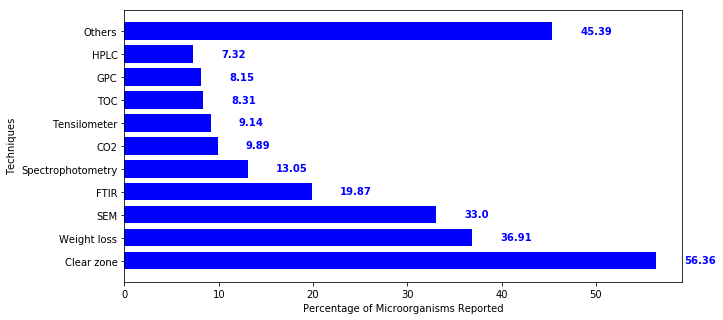

In [80]:
evidence_dict = {}
count = 0

for index, row in df.iterrows():
    evidence_line = row['Evidence']
    count += 1
    for evidence in str(evidence_line).split(";"):
        if evidence not in evidence_dict:
            evidence_dict[evidence] = 1
        else:
            evidence_dict[evidence] += 1


bars, height, percentages = [], [], []
count2, others = 0, 0
for item,value in sorted(evidence_dict.items(), key=lambda x: x[1], reverse=True):
    print(item+" = "+str(round(((value/count)*100), 2))+"%")
    if count2 < 10:
        bars.append(item)
        height.append(value)
        percentages.append(round(((value/count)*100), 2))
    elif count2 < 55:
        others += value
    else:
        bars.append("Others")
        height.append(others)
        percentages.append(round(((others/count)*100), 2))
    count2 += 1
        
fig, ax = plt.subplots()    
fig.set_size_inches(10, 5)
width = 0.75 # the width of the bars 
ind = np.arange(len(percentages))  # the x locations for the groups
ax.barh(ind, percentages, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Techniques')
plt.xlabel('Percentage of Microorganisms Reported')
for i, v in enumerate(percentages):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

<a id='Creating-figure-with-analitical-grade-plastic'></a>
# Creating figure with analitical grade plastic

Yes = 24.52%
No = 17.71%


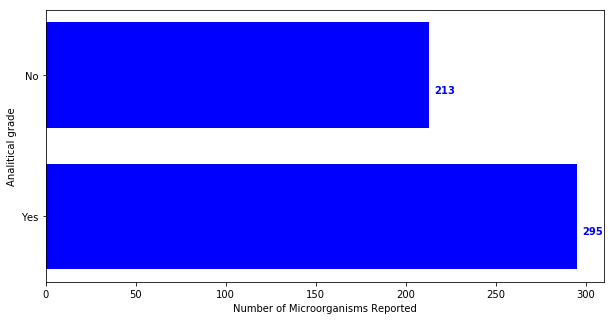

In [150]:
analitical_grade_dict = {}
count = 0

for index, row in df.iterrows():
    analitical_grade = row['Analitical grade']
    count += 1
    if pd.isna(df.at[index, 'Analitical grade']):
        count5 = 1
    elif analitical_grade == "Fill me out" or analitical_grade == "Fill me out ":
        count5 = 1        
    elif analitical_grade not in analitical_grade_dict:
        analitical_grade_dict[analitical_grade] = 1
    else:
        analitical_grade_dict[analitical_grade] += 1

bars, height = [], []   

for item,value in sorted(analitical_grade_dict.items(), key=lambda x: x[1], reverse=True):
    print(str(item)+" = "+str(round(((value/count)*100), 2))+"%")
    bars.append(item)
    height.append(value)

fig, ax = plt.subplots()    
fig.set_size_inches(10, 5)
width = 0.75 # the width of the bars 
ind = np.arange(len(height))  # the x locations for the groups
ax.barh(ind, height, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Analitical grade')
plt.xlabel('Number of Microorganisms Reported')
for i, v in enumerate(height):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

<a id='Creating-figure-with-manufacturer'></a>
# Creating figure with manufacturer

Sigma Aldrich = 13.38%
Showa Denko = 6.57%
Mitsubishi Gas Chemical = 3.49%
Bayer  = 3.41%
ICI, UK = 2.74%
Shimadzu = 2.66%
Daicel Chemical Industries = 2.58%
Panara = 2.33%
Polymer Institute, SAS = 2.0%
Union Carbide = 1.91%
Nippon Shokubai = 1.66%
Local market = 1.41%
BASF = 1.41%
Wako Pure Chemical = 1.41%
RB Industries = 1.16%
POLICHEM = 1.0%
Monsanto = 1.0%
NatureWorks LLC = 1.0%
Polymer and Petrochemical Institute (IPPI) = 0.91%
Biopolis = 0.91%
Toagosei = 0.75%
LACEA = 0.75%
Polysciences = 0.75%
Archer-Daniels-Midland = 0.67%
Alfa-Asar Company = 0.58%
Zeneca Bioproducts = 0.58%
TRESNO = 0.58%
Gwalior Plastic Industry  = 0.5%
SKI = 0.5%
Bulk Reef Supply = 0.5%
Covestro = 0.5%
Pemex = 0.42%
Goodfellow Cambridge = 0.42%
Apexa = 0.42%
Indian Institute of petroleum (IIP), CSIR = 0.33%
Miles = 0.33%
SRF = 0.33%
Reliance Industries = 0.33%
Biological Sciences and Earth Science laboratories = 0.33%
CIBA = 0.33%
Tokuyama = 0.25%
Kaneka Biodegrable = 0.25%
Iran’s National Petrochemical Com

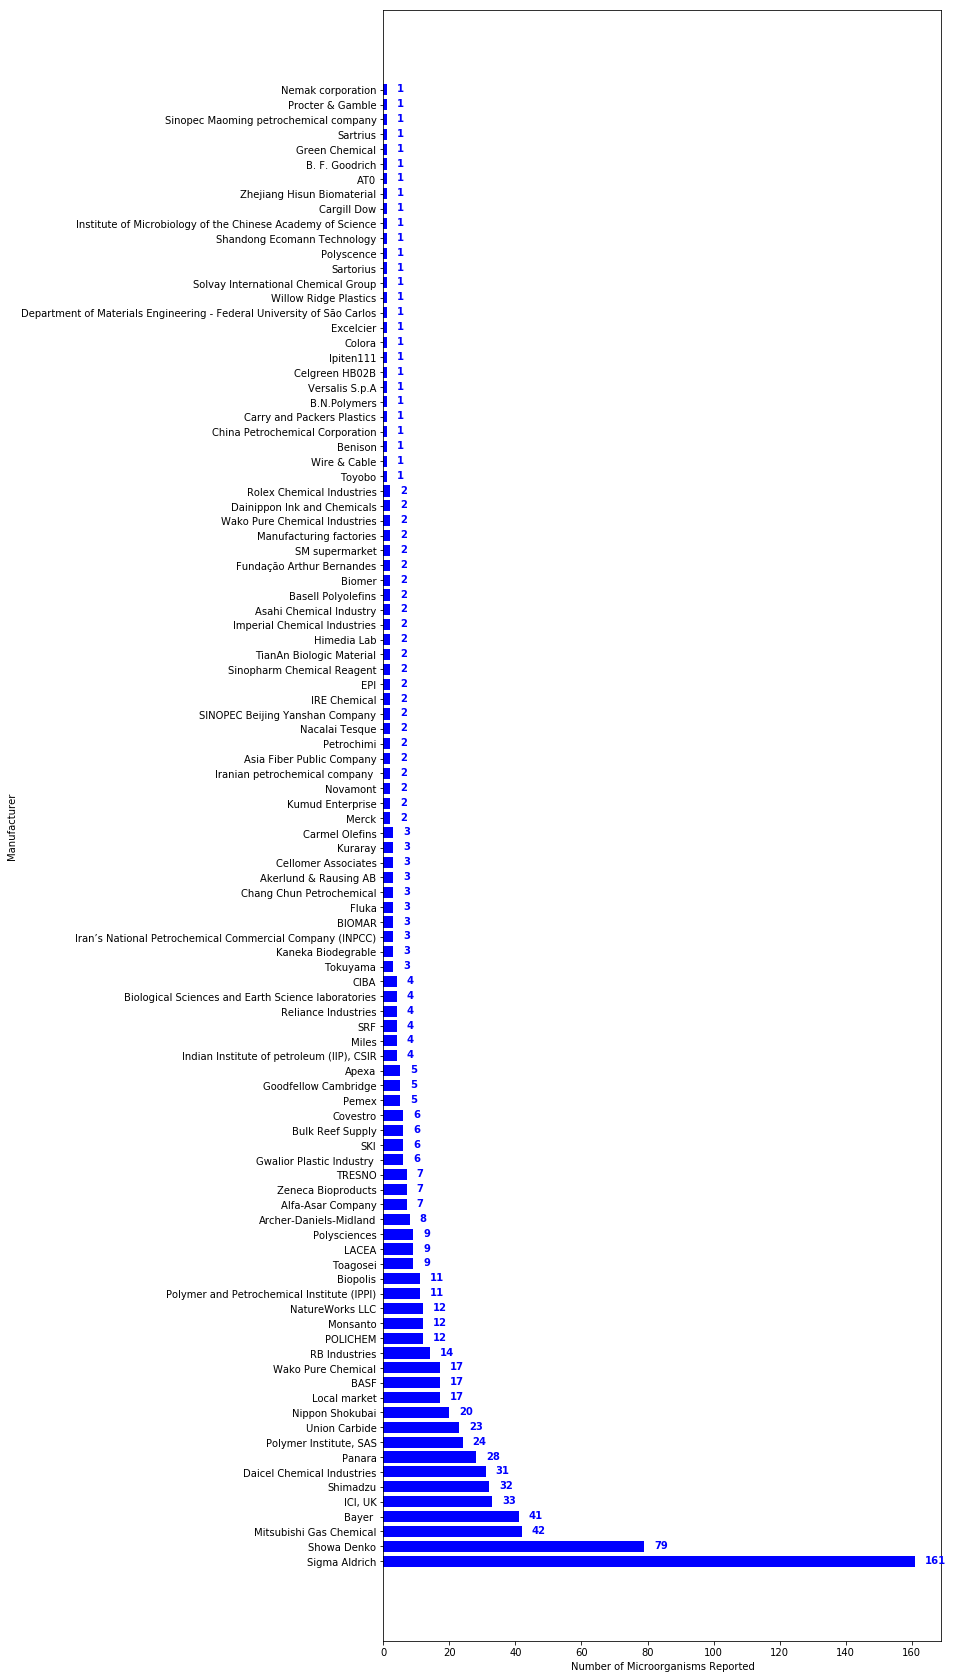

In [145]:
fig_dict = {}
count = 0

for index, row in df.iterrows():
    fig_line = row['Manufacturer']
    count += 1
    for fig_data in str(fig_line).split(";"):
        if pd.isna(df.at[index, 'Manufacturer']):
            count5 = 1
        elif fig_data not in fig_dict:
            fig_dict[fig_data] = 1
        else:
            fig_dict[fig_data] += 1


bars, height = [], []            
for item,value in sorted(fig_dict.items(), key=lambda x: x[1], reverse=True):
    print(item+" = "+str(round(((value/count)*100), 2))+"%")
    bars.append(item)
    height.append(value)

fig, ax = plt.subplots()    
fig.set_size_inches(10, 30)
width = 0.75 # the width of the bars 
ind = np.arange(len(height))  # the x locations for the groups
ax.barh(ind, height, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Manufacturer')
plt.xlabel('Number of Microorganisms Reported')
for i, v in enumerate(height):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

<a id='Creating-figure-with-thermophilic-data'></a>
# Creating figure with thermophilic data

No = 86.87%
Yes = 10.39%


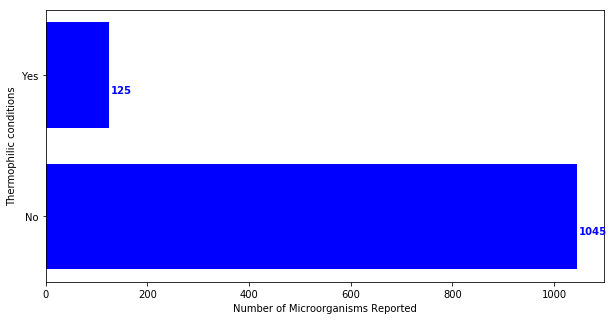

In [142]:
fig_dict = {}
count = 0

for index, row in df.iterrows():
    fig_data = row['Thermophilic conditions']
    count += 1
    if pd.isna(df.at[index, 'Thermophilic conditions']):
        count5 = 1
    elif fig_data != "Yes" and fig_data != "No":
        count5 = 1
    elif fig_data not in fig_dict:
        fig_dict[fig_data] = 1
    else:
        fig_dict[fig_data] += 1

bars, height = [], []   

for item,value in sorted(fig_dict.items(), key=lambda x: x[1], reverse=True):
    print(str(item)+" = "+str(round(((value/count)*100), 2))+"%")
    bars.append(item)
    height.append(value)

fig, ax = plt.subplots()    
fig.set_size_inches(10, 5)
width = 0.75 # the width of the bars 
ind = np.arange(len(height))  # the x locations for the groups
ax.barh(ind, height, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Thermophilic conditions')
plt.xlabel('Number of Microorganisms Reported')
for i, v in enumerate(height):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

<a id='Creating-figure-with-isolation-environment'></a>
# Creating figure with isolation environment

Soil = 27.76%
Collection = 15.88%
Plastic waste dumping site = 9.56%
Compost = 5.32%
Marine = 4.32%
Landfill = 2.99%
Sewage/Sludge = 2.83%
River/Lake = 2.24%
Plant associated = 1.91%
Mangrove = 1.75%
Others = 0.91%
Animal associated = 0.5%
Hot spring = 0.5%
Marine environment  = 0.08%


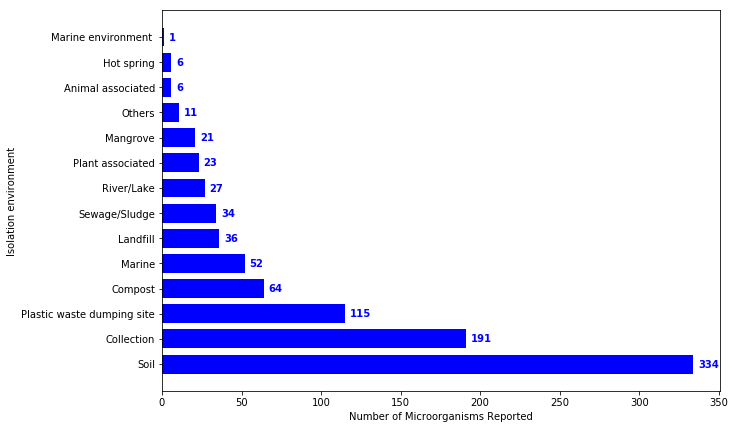

In [137]:
fig_dict = {}
count = 0

for index, row in df.iterrows():
    fig_data = row['Isolation environment']
    count += 1
    if pd.isna(df.at[index, 'Isolation environment']):
        count5 = 1
    elif fig_data not in fig_dict:
        fig_dict[fig_data] = 1
    else:
        fig_dict[fig_data] += 1

bars, height = [], []   

for item,value in sorted(fig_dict.items(), key=lambda x: x[1], reverse=True):
    print(str(item)+" = "+str(round(((value/count)*100), 2))+"%")
    bars.append(item)
    height.append(value)

fig, ax = plt.subplots()    
fig.set_size_inches(10, 7)
width = 0.75 # the width of the bars 
ind = np.arange(len(height))  # the x locations for the groups
ax.barh(ind, height, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Isolation environment')
plt.xlabel('Number of Microorganisms Reported')
for i, v in enumerate(height):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

<a id='Creating-figure-with-isolation-location'></a>
# Creating figure with isolation location

Japan = 14.13%
India = 13.8%
Slovakia = 4.32%
Spain = 3.16%
Thailand = 2.99%
South Korea = 2.58%
Iran = 2.33%
Germany = 1.5%
Vietnam = 1.41%
Taiwan = 1.41%
Svalbard = 1.41%
Belgium = 1.25%
UK = 1.16%
China = 1.16%
Poland = 1.08%
Pakistan = 1.08%
USA = 1.0%
Turkey = 0.83%
Malaysia = 0.83%
Mexico = 0.58%
Switzerland = 0.5%
Brazil = 0.5%
Philippines = 0.42%
Jordan = 0.33%
France = 0.33%
Ecuador = 0.25%
Indonesia = 0.25%
Kenya = 0.25%
Egypt = 0.25%
North Sea = 0.17%
Russia = 0.17%
Italy = 0.17%
Pacific Ocean = 0.17%
Antarctic Ocean = 0.17%
Nigeria = 0.17%
Iraq = 0.08%
Bay of Bengal = 0.08%
Morocco = 0.08%
Israel = 0.08%
Sweden = 0.08%
Ukraine = 0.08%
Bulgaria = 0.08%
Thaiti = 0.08%
Saudi Arabia = 0.08%
Ireland = 0.08%
Czech Republic = 0.08%


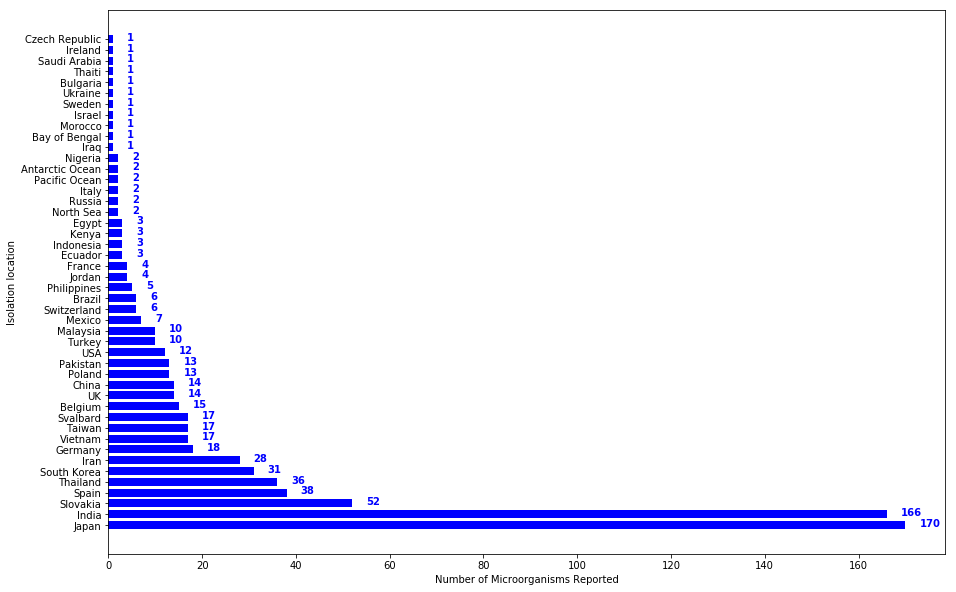

In [139]:
fig_dict = {}
count = 0

for index, row in df.iterrows():
    fig_data = row['Isolation location']
    count += 1
    if pd.isna(df.at[index, 'Isolation location']):
        count5 = 1
    elif fig_data not in fig_dict:
        fig_dict[fig_data] = 1
    else:
        fig_dict[fig_data] += 1

bars, height = [], []   

for item,value in sorted(fig_dict.items(), key=lambda x: x[1], reverse=True):
    print(str(item)+" = "+str(round(((value/count)*100), 2))+"%")
    bars.append(item)
    height.append(value)

fig, ax = plt.subplots()    
fig.set_size_inches(15, 10)
width = 0.75 # the width of the bars 
ind = np.arange(len(height))  # the x locations for the groups
ax.barh(ind, height, width, color="blue", align='edge')
ax.set_yticks(ind+width/2)
ax.set_yticklabels(bars, minor=False)
plt.ylabel('Isolation location')
plt.xlabel('Number of Microorganisms Reported')
for i, v in enumerate(height):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
 
# Show graphic
plt.show()

country_names = bars
country_values = height

<a id='Creating-figure-with-global-distribution'></a>
# Creating figure with global distribution

In [118]:
import folium

country_values2 = []
for item in country_values:
    country_values2.append(float(item))
    

countries_geo = "world-countries.json"
 
countries_degraders = pd.DataFrame(country_values2[1:],country_names[1:], columns = ["Degraders"])
countries_degraders['Names'] = countries_degraders.index
countries_degraders["Lat"] = ""
countries_degraders["Lon"] = ""
coordinates = pd.read_csv("world-countries-coord.tsv", sep='\t')

for index, row in countries_degraders.iterrows():
    country = row["Names"]
    for index2, row2 in coordinates.iterrows():
        country2 = row2["Names"]
        lat = row2["Latitude"]
        lon = row2["Longitude"]
        if country == country2:
            countries_degraders.at[country,"Lat"] = lat
            countries_degraders.at[country,"Lon"] = lon
countries_degraders




 
# Make an empty map
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
 
# I can add marker one by one on the map
for i in range(0,len(countries_degraders)):
    print(countries_degraders.iloc[i]['Names'])
    folium.Circle(
      location=[countries_degraders.iloc[i]['Lat'], countries_degraders.iloc[i]['Lon']],
      popup=countries_degraders.iloc[i]['Names'],
      radius=countries_degraders.iloc[i]['Degraders']*6000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
 
# # Save it as html
# m.save('mymap.html')
m

Japan
India
Slovakia
Spain
Thailand
South Korea
Iran
Germany
Vietnam
Taiwan
Svalbard
Belgium
UK
China
Poland
Pakistan
USA
Turkey
Malaysia
Mexico
Switzerland
Brazil
Philippines
Jordan
France
Ecuador
Indonesia
Kenya
Egypt
North Sea
Russia
Italy
Pacific Ocean
Antarctic Ocean
Nigeria
Iraq
Bay of Bengal
Morocco
Israel
Sweden
Ukraine
Bulgaria
Thaiti
Saudi Arabia
Ireland
Czech Republic


<a id='Exporting-DB-to-website'></a>
# Exporting DB to website

In [44]:
df.to_csv(r'degraders_list_v2.tsv', index=False, sep='\t')

<a id='Creating-Venn-Diagram'></a>
# Creating Venn Diagram

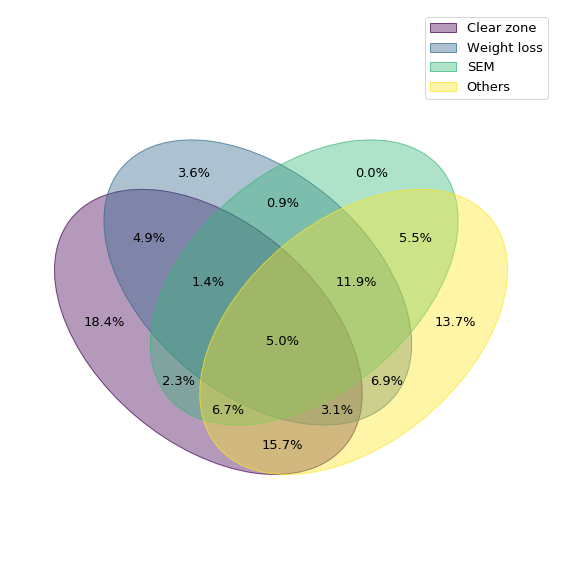

In [132]:
from venn import venn
%matplotlib inline

techniques = {"Clear zone": {""}, "Weight loss": {""}, "SEM": {""}, "Others": {""}}
for index, row in df.iterrows():
    evidence_line = row['Evidence']
    for evidence in str(evidence_line).split(";"):
        if evidence == "Clear zone":
            techniques["Clear zone"].add(index)
        elif evidence == "Weight loss":
            techniques["Weight loss"].add(index)
        elif evidence == "SEM":
            techniques["SEM"].add(index)
        elif evidence == "nan":
            count = 1
        else:
            techniques["Others"].add(index)
            
venn(techniques, fmt="{percentage:.1f}%", figsize=(10, 10))

<a id='Creating-Venn-Diagram'></a>
# Exporting df2

In [48]:
df2.to_csv(r'df2.tsv', index=False, sep='\t')